In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output
import time
import matplotlib.patches as patches


#import sys
#sys.setrecursionlimit(100000000)

In [ ]:
# reading the excel file
df_start = pd.read_excel('worldcities.xlsx')

#get a data frame with selected columns
FORMAT = ['city', 'lat', 'lng','country','iso2','population']
df_selected = df_start[FORMAT]

#insert in the dataframe the flag for the population
df_selected["flg_pop"]=df_selected.population.apply(lambda x: 1 if not(pd.isna(x)) and x > 200000 else 0)#(0 if pd.isna(x) else 0))

# sorting values by longitude
df_selected.sort_values(by=['lng'], inplace=True, ignore_index=True)

# searching the index of London (GB)
rslt_df = df_selected.loc[(df_selected['city'] == 'London') & 
              (df_selected['iso2']=='GB')] 
index_of_london = rslt_df.index[0]

# splitting the dataframe before and after the London index
df_a = df_selected.iloc[:index_of_london]
df_b = df_selected.iloc[index_of_london:]

# reshaping of dataframe
df = df_b.append(df_a).reset_index(drop=True)

In [8]:
class AroundTheWorld(object):
    
    def __init__(self, dataframe, city_start, country_start, n_min=3, x_size=0.3, y_size=0.1):
        self.dataframe=dataframe
        self.coord_step=None #(lng, lat) city_step
        self.lat_max=None
        self.lat_min=None
        self.lng_min=None
        self.lng_max=None
        self.city_start=city_start
        self.country_start=country_start
        self.city_step=city_start
        self.country_step=country_start
        self.n_min=n_min
        self.x_size=x_size
        self.y_size=y_size
        self.hours=0
        self.n_step=0
        self.dataframe["visited_city"]=0
        self.x_size_default=x_size
        self.y_size_default=y_size
        self.lat_inf=None
        self.lat_sup=None
        self._calculate_lat()
        self.map_city=pd.DataFrame([], columns=self.dataframe.columns)
        #self.is_near_start_city = False
            
    def _calculate_lat(self):
        #print(self.dataframe.loc[(self.dataframe['city'] == self.city_start) & (self.dataframe['iso2']== self.country_start)][['lng','lat']])
        self.coord_start = tuple(self.dataframe.loc[
            (self.dataframe['city'] == self.city_start) &
            (self.dataframe['iso2']== self.country_start)][['lng','lat']].iloc[0])
        self.coord_step = self.coord_start

        
    def generate_grid(self):
        if self.coord_step[1] >= self.coord_start[1]:
            self.lat_max=self.coord_step[1]+self.y_size/2
            self.lat_min=self.coord_start[1]-self.y_size/2
        else:
            self.lat_max=self.coord_start[1]+self.y_size/2
            self.lat_min=self.coord_step[1]-self.y_size/2
            
        self.lng_min=self.coord_step[0]
        self.lng_max=self.coord_step[0]+self.x_size
        
        if self.lat_max >= 90:
            self.lat_max -= 180
        if self.lat_min <= -90:
            self.lat_min += 180
        if self.lng_max >= 180:
            self.lng_max -= 360
        if self.lng_min <= -180:
            self.lng_min += 360
        #print(self.lat_max, self.lat_min, self.lng_min, self.lng_max)
        
    def query(self): 
        if (self.lat_min >= 0 and self.lat_max>=0) or (self.lat_min <= 0 and self.lat_max<=0):
            lat_condition = (self.dataframe["lat"] >= self.lat_min) & (self.dataframe["lat"] <= self.lat_max)
        elif self.lat_min >=0 and self.lat_max<=0:
            lat_condition = ((self.dataframe["lat"] >= self.lat_min) & (self.dataframe["lat"] <= 90)) | ((self.dataframe["lat"] >= -90) & (self.dataframe["lat"] <= self.lat_max))
        elif self.lat_min<=0 and self.lat_max >=0:
            lat_condition = ((self.dataframe["lat"] >= self.lat_min) & (self.dataframe["lat"] <= 0)) | ((self.dataframe["lat"] >= 0) & (self.dataframe["lat"] < self.lat_max))
        else:
            lat_condition = False
            
        if (self.lng_min >= 0 and self.lng_max>=0) or (self.lng_min <= 0 and self.lng_max<=0):
            lng_condition = (self.dataframe["lng"] >= self.lng_min) & (self.dataframe["lng"] <= self.lng_max)
        elif self.lng_min >=0 and self.lng_max<=0:
            lng_condition = ((self.dataframe["lng"] >= self.lng_min) & (self.dataframe["lng"] <= 180)) | ((self.dataframe["lng"] >= -180) & (self.dataframe["lng"] <= self.lng_max))
        elif self.lng_min<=0 and self.lng_max >=0:
            lng_condition = ((self.dataframe["lng"] >= self.lng_min) & (self.dataframe["lng"] <= 0)) | ((self.dataframe["lng"] >= 0) & (self.dataframe["lng"] < self.lng_max))
        else:
            lng_condition = False
            
        grid_city=self.dataframe.loc[(lat_condition) & (lng_condition) &    
                                     (self.dataframe["city"] != self.city_step) &
                                     (self.dataframe["visited_city"] == 0)]
        #print(grid_city)
        return grid_city
    
    def check_if_stop_city_is_in_grid(self, grid_city):
        #print(grid_city)
        temp_grid_city = grid_city.loc[(grid_city["lng"] == self.coord_start[0]) &
                          (grid_city["lat"] == self.coord_start[1])]
        #print(temp_df)
        check_condition=len(temp_grid_city) == 1
        return check_condition    
        
    def check_grid_city(self):
        self.generate_grid()
        grid_city=self.query()
        n_row=grid_city.shape[0]
        if n_row < self.n_min:
            self.x_size *= 2
            self.y_size *= 2 #1.9 # 1.85
            return self.check_grid_city() 
        else: 
            self.x_size = self.x_size_default
            self.y_size = self.y_size_default
            return grid_city
        #print(n_row)
        
    
    def weight(self, grid_city):
        
        grid_city["distance"]=grid_city.apply(self.calculate_distance, axis=1, point_city_step=self.coord_step )
        grid_city.sort_values(by=['distance'], inplace=True)

        grid_city=grid_city[:self.n_min]
        grid_city["weight"] = [2**x for x in range(1,self.n_min+1)]
        grid_city["weight"] += grid_city.apply(self.calculate_weigth, axis=1, country_step=self.country_step)
        
        return grid_city
    
    def stop_condition(self, grid_city):
        temp_grid_city=grid_city.loc[(grid_city["lng"] == self.coord_start[0]) & (grid_city["lat"] == self.coord_start[1])]
        if len(temp_grid_city)==1:
            grid_city =temp_grid_city
        return grid_city
            
    @staticmethod #decorator
    def calculate_weigth(row, country_step):
        pop_weigth=2 if row['flg_pop'] == 1 else 0
        country_weigth=2 if row['iso2'] != country_step else 0
        return pop_weigth + country_weigth
    
    @staticmethod
    def calculate_distance(row, point_city_step):
        return euclidean_distances([list(point_city_step)], [[row['lng'],row['lat']]])[0][0]
             
    def step(self, grid_city):
        grid_city.sort_values(by=["weight","distance"], ascending=[True, False], inplace=True)
        step=grid_city.iloc[0]
        self.coord_step=tuple(step[["lng", "lat"]])
        self.city_step=step["city"]
        self.country_step=step["iso2"]
        self.hours += step["weight"]
        self.dataframe["visited_city"].iloc[step.name] = 1
        self.map_city=self.map_city.append(step)
        #print(self.map_city)
        #print(self.coord_step, self.city_step, self.country_step, self.hours)
        
    def travel(self):
        while ((self.city_start != self.city_step) or (self.country_start != self.country_step) or (self.n_step == 0)):
            grid_city = self.check_grid_city()
            grid_city_weight= self.weight(grid_city)
            grid_city_weight=self.stop_condition(grid_city_weight)
            self.step(grid_city_weight)
            self.n_step += 1
            #print(self.dataframe)
            if self.n_step!= 0 and self.n_step % 100==0:
                #print(self.n_step)
                self.plot_world()
        self.plot_world()
        print(self.n_step, self.hours)
        print(self.map_city)
        
    
    def plot_world(self):
        #clear_output(wait=True)
        visited_df = self.dataframe.loc[(self.dataframe["visited_city"] == 1)]
        city_df = self.dataframe.loc[(self.dataframe["visited_city"] == 0)]
        
        fig = plt.figure(figsize=(100,50))
        ax = fig.add_subplot(111)
        ax.scatter(city_df.lng,city_df.lat, color="green", marker="o", alpha=0.5, s=30)
        ax.scatter(visited_df.lng,visited_df.lat, color="magenta", marker="o", alpha=0.5, s=200)
        ax.scatter(self.coord_start[0],self.coord_start[1],color="red", marker="o", s=100)
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        ax.grid()

        ax.add_patch(
            patches.Rectangle(
                xy=(self.lng_min, self.lat_min),  # point of origin.
                width=self.lng_max - self.lng_min,
                height=self.lat_max - self.lat_min,
                linewidth=1,
                color='blue',
                fill=False
            )
        )
        
        
        plt.show()
        


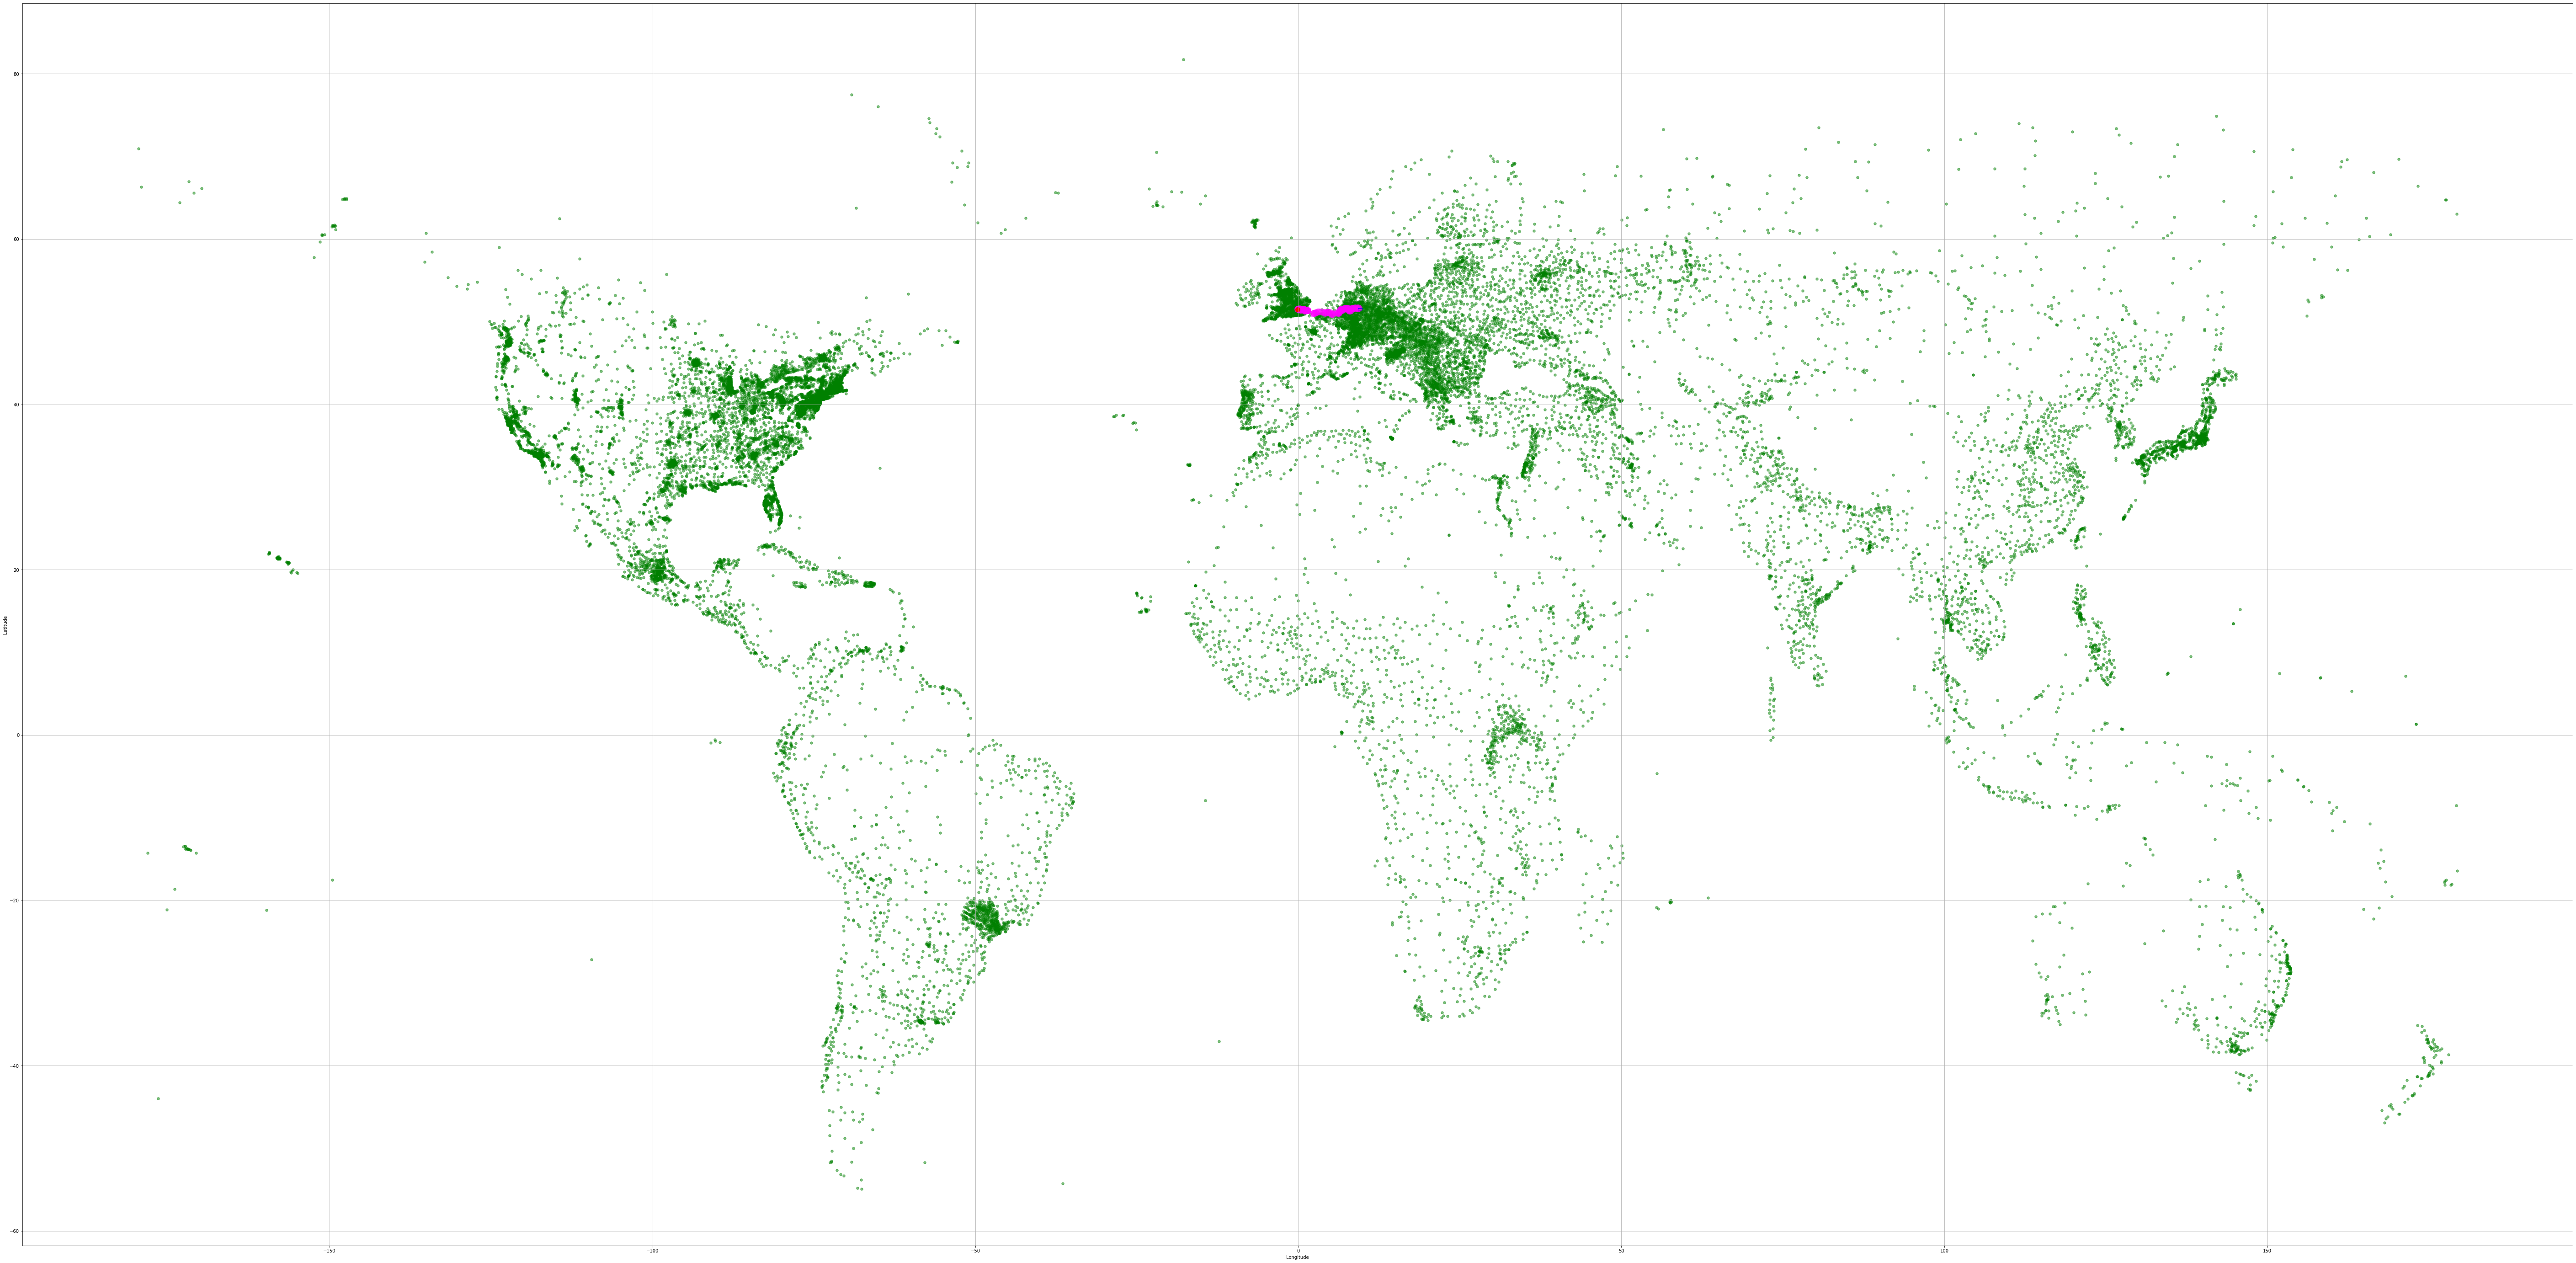

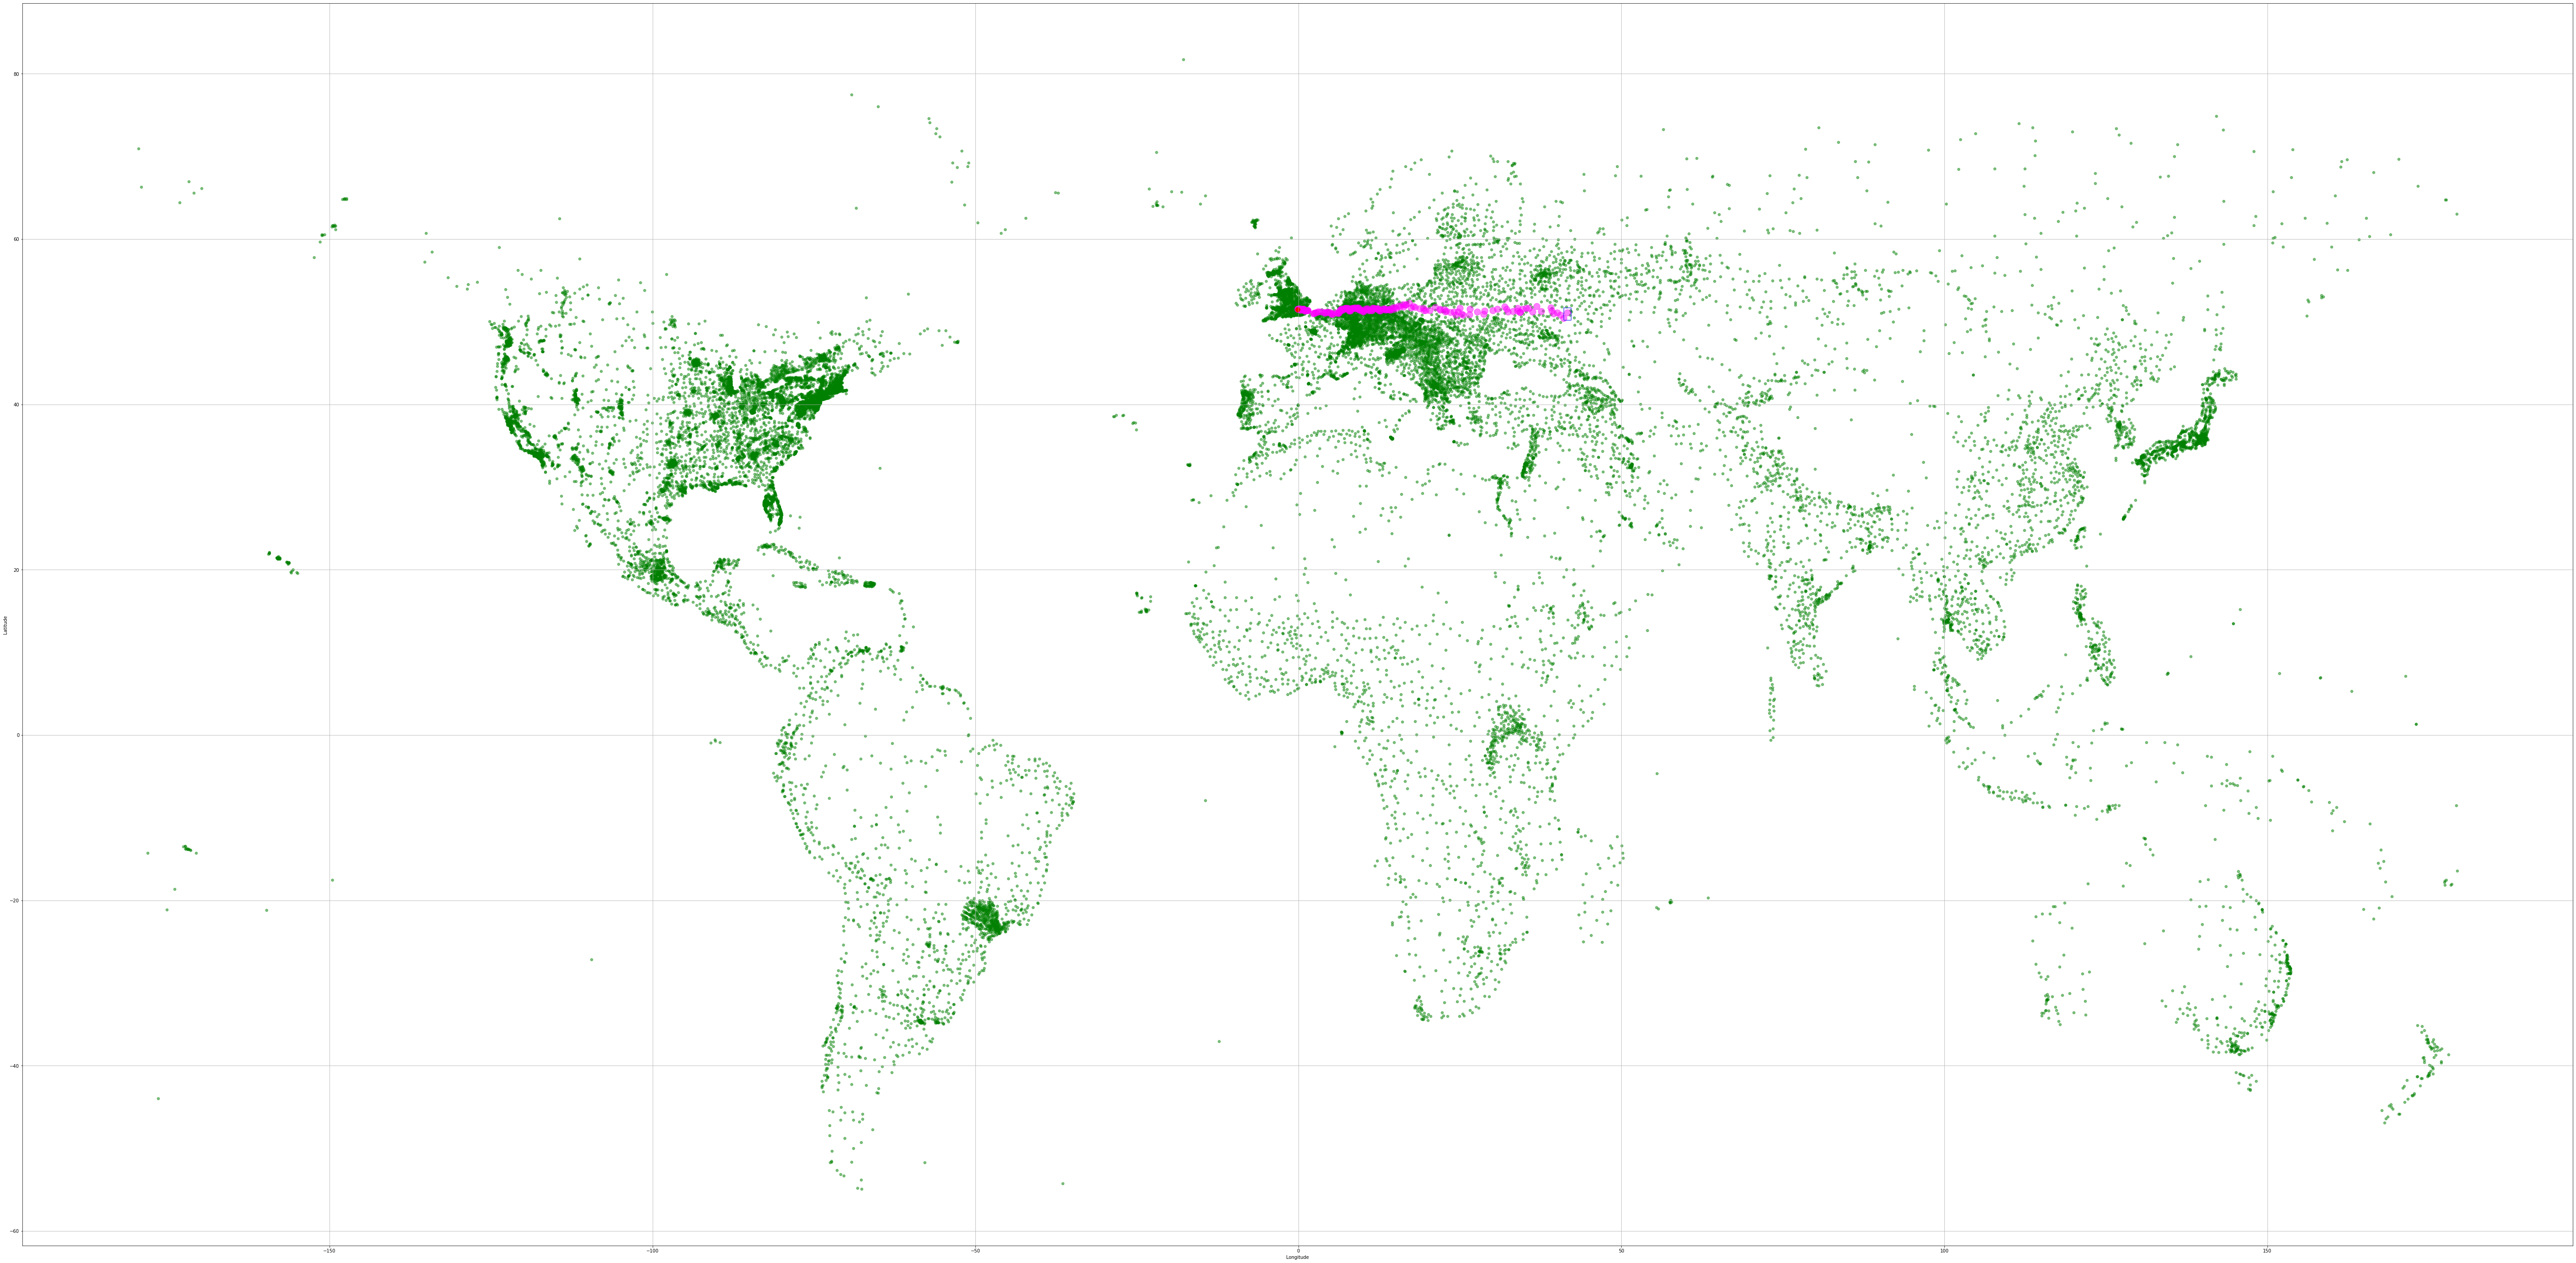

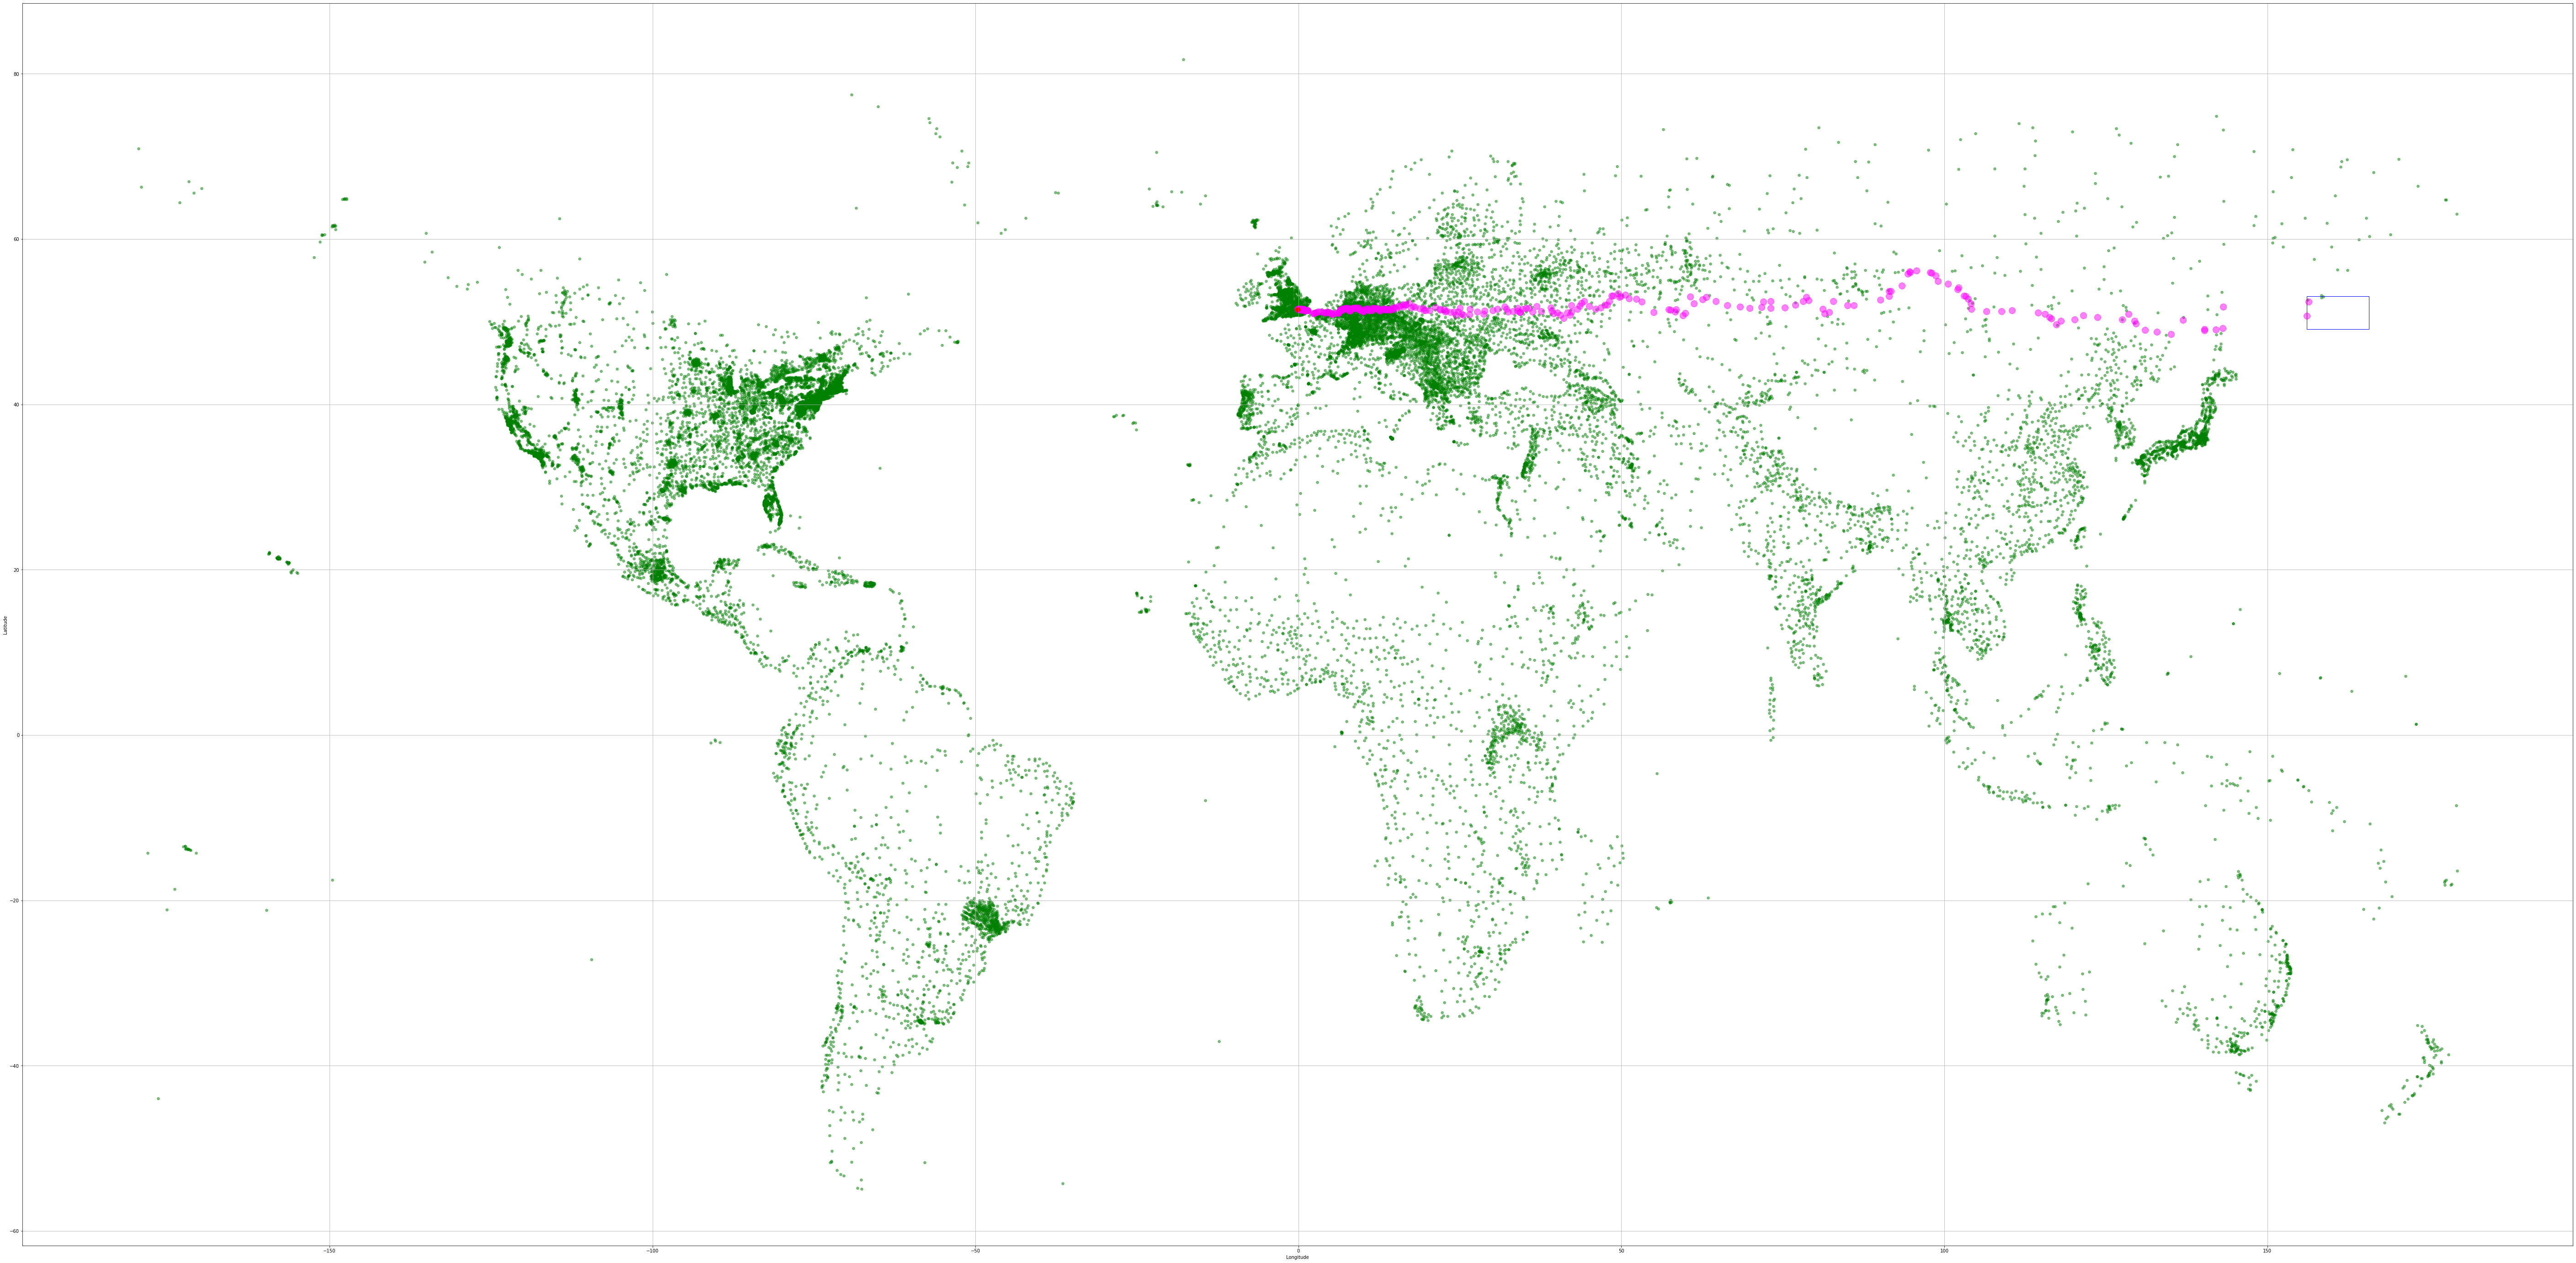

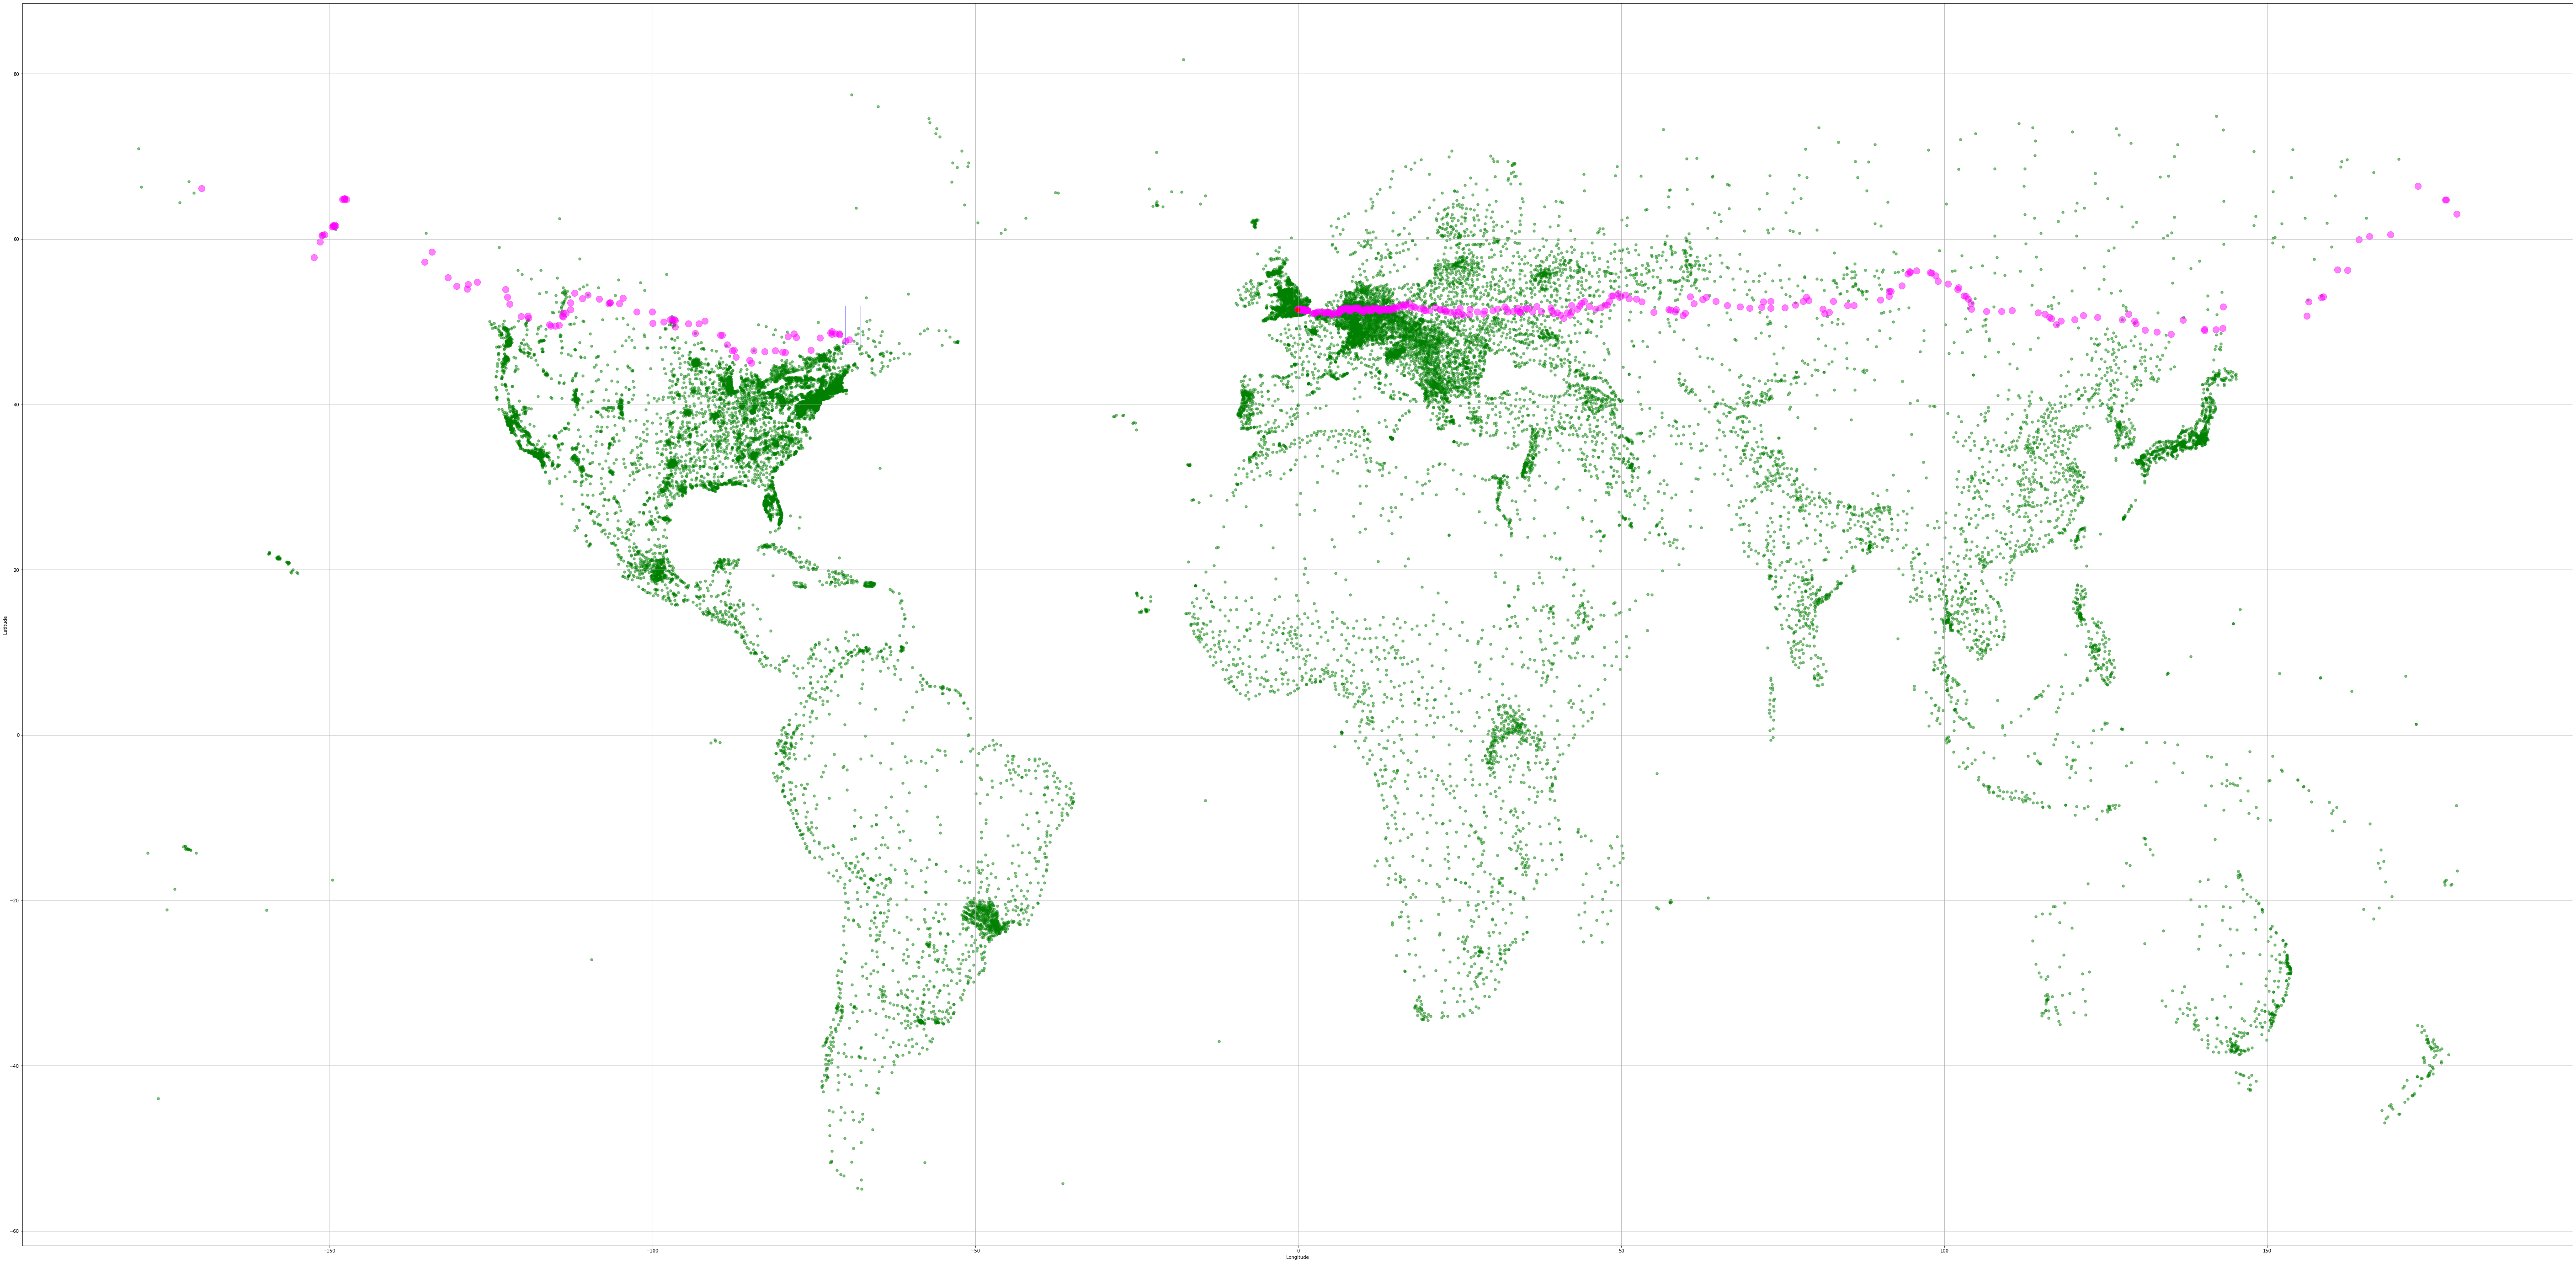

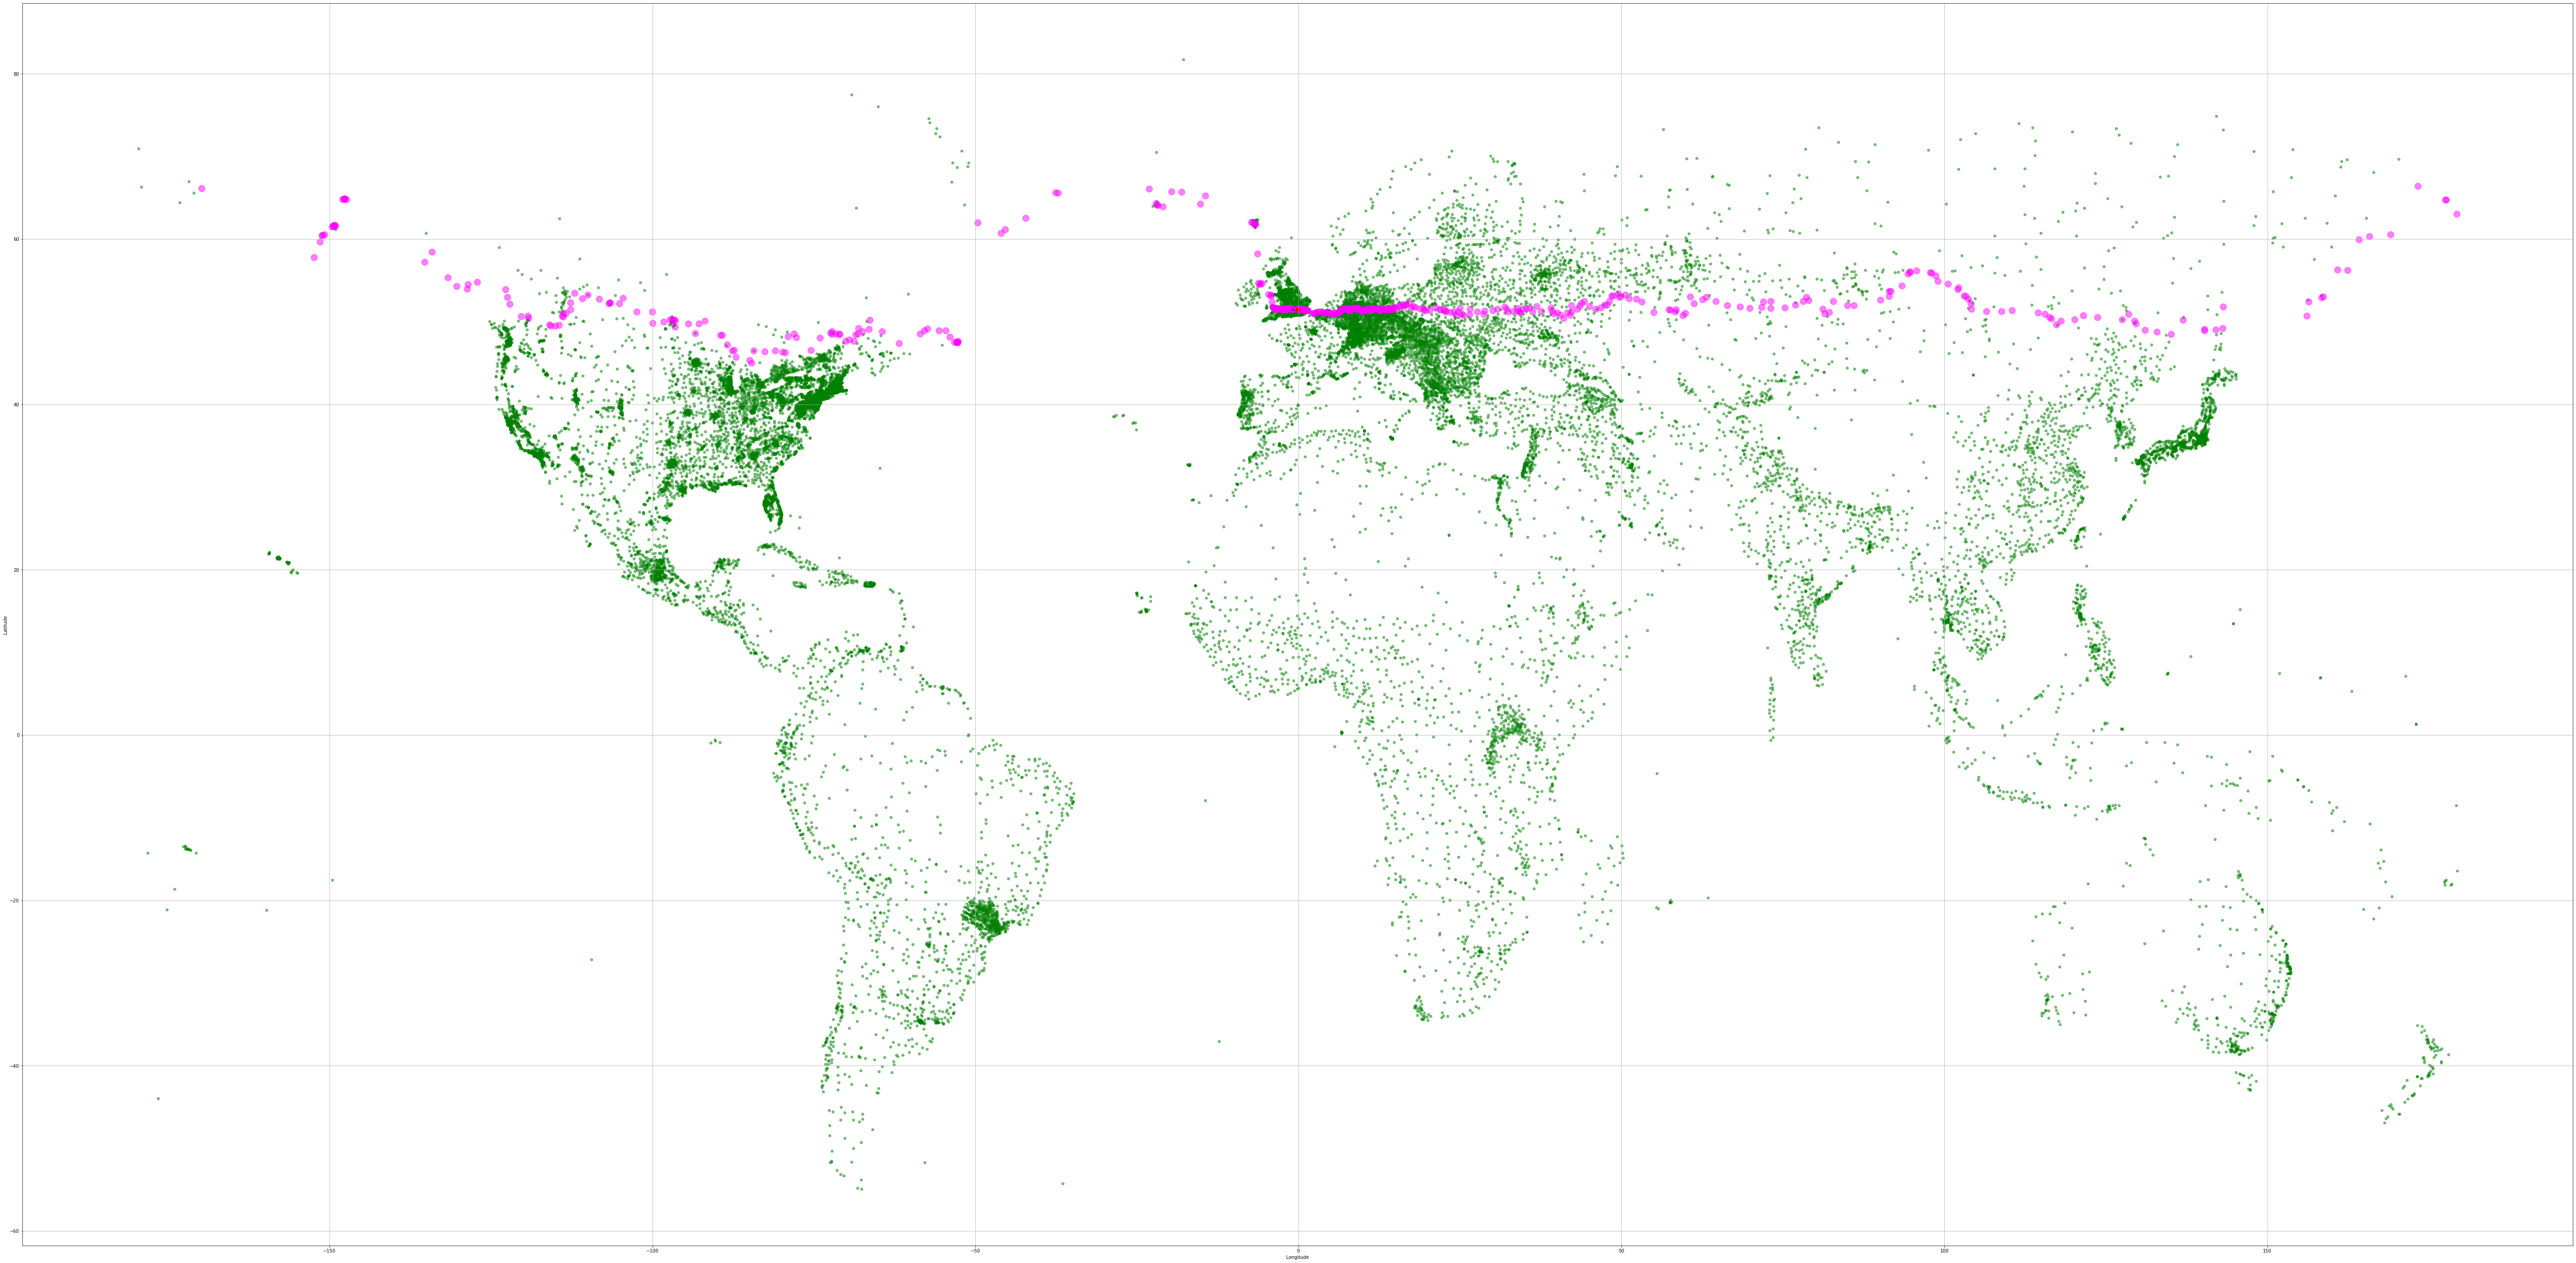

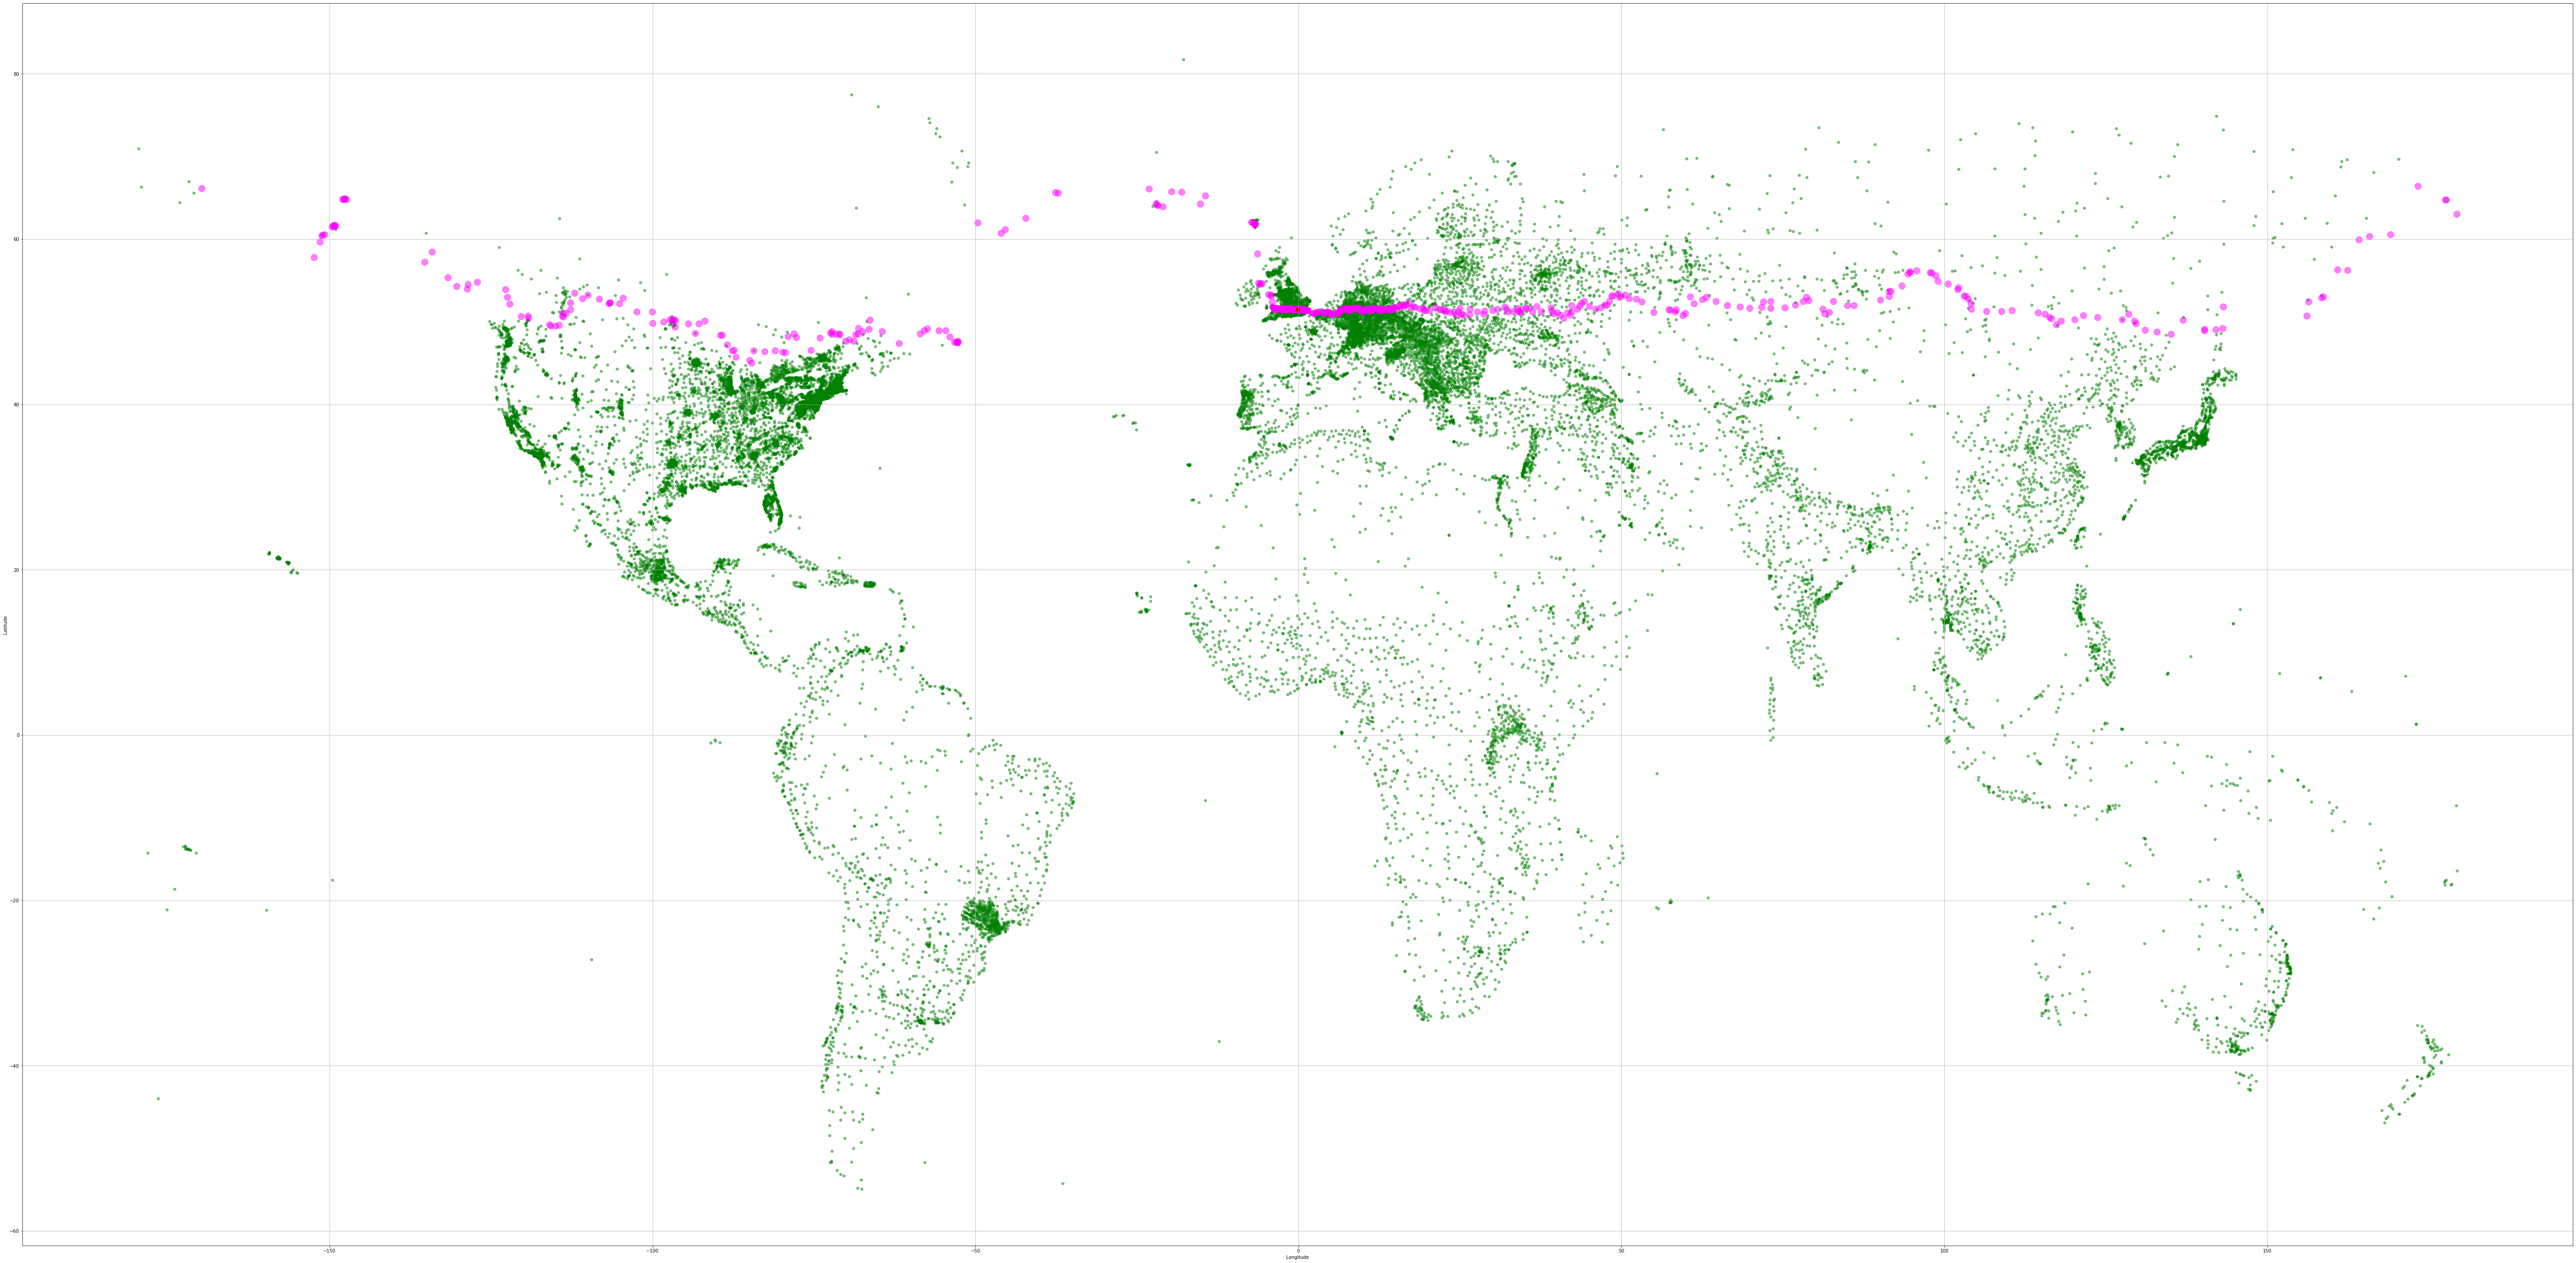

527 1206
               city      lat     lng         country iso2  population flg_pop  \
6           Holborn  51.5172 -0.1182  United Kingdom   GB     13023.0       0   
18         Highbury  51.5520 -0.0970  United Kingdom   GB     26664.0       0   
29     Spitalfields  51.5166 -0.0750  United Kingdom   GB     10286.0       0   
40          Stepney  51.5152 -0.0462  United Kingdom   GB     16238.0       0   
44          Hackney  51.5414 -0.0266  United Kingdom   GB     11734.0       0   
...             ...      ...     ...             ...  ...         ...     ...   
26483       Wembley  51.5528 -0.2979  United Kingdom   GB    102856.0       0   
26495         Acton  51.5135 -0.2707  United Kingdom   GB     62480.0       0   
26518     Kew Green  51.5308 -0.2248  United Kingdom   GB     14915.0       0   
26537    Kensington  51.5000 -0.1900  United Kingdom   GB     64681.0       0   
0            London  51.5072 -0.1275  United Kingdom   GB  10979000.0       1   

      visited_city

In [9]:
#(-0.1275, 51.5072)
around = AroundTheWorld(df, "London", "GB")#''', x_size=1, y_size=0.5'''
#around.generate_grid()
#k=around.query()
#around.check_grid_city()
#h=around.weight(k)
#around.step(h)
around.travel()